## 32 - Multiplanel Animations

[Youtube](https://www.youtube.com/watch?v=ewweEyqMb-A)

In [1]:
from siphon.catalog import TDSCatalog
cat = TDSCatalog('http://thredds.ucar.edu/thredds/radarServer/catalog.xml')
list(cat.catalog_refs)

['NEXRAD Level II Radar for Case Study CCS039',
 'NEXRAD Level II Radar from IDD',
 'NEXRAD Level III Radar for Case Study CCS039',
 'NEXRAD Level III Radar from IDD',
 'TDWR Level III Radar from IDD']

In [2]:
from siphon.radarserver import RadarServer
rs = RadarServer(cat.catalog_refs['NEXRAD Level II Radar from IDD'].href)

In [3]:
from datetime import datetime, timedelta
query = rs.query()
now = datetime.utcnow()
query.stations('KBOX').time_range(now - timedelta(hours = 1), now).variables('N0Q')

var=N0Q&time_start=2024-01-11T00%3A40%3A44.053931&time_end=2024-01-11T01%3A40%3A44.053931&stn=KBOX

In [4]:
catalogs = []
for code in ['N0Q', 'N0C', 'N0H', 'N0X']:
	query.var = set()
	query.variables(code)
	catalogs.append(rs.get_catalog(query))

In [5]:
catalog = rs.get_catalog(query)

In [6]:
from metpy.plots import ctables

In [7]:
colormapping = {'Reflectivity': ctables.registry.get_with_steps('NWSReflectivity', 5, 5)}

In [8]:
def plot_radar(data, field_name):
	# Look for a cmap and norm specified above for the field name. If not found, default
	# to None for both, which will cause matplotlib to choose defaults
	norm, cmap = colormapping.get(field_name, (None, None))
	
	rng = data.variables['distanceR'][:]
	az = data.variables['azimuthR'][:]
	ref = data.variables[field_name][:]
	
	# Set limit in lat/lon space
	ax.set_extent([data.StationLongitude - .75, data.StationLongitude + .75, data.StationLatitude - .75, data.StationLatitude + .75], crs = cartopy.crs.PlateCarree())
	
	x = rng * np.sin(np.deg2rad(az))[:, :, None]
	y = rng * np.cos(np.deg2rad(az))[:, :, None]
	ref = np.ma.array(ref, mask = np.isnan(ref))
	level = 0
	mesh = ax.pcolormesh(x[level,:,:], y[level,:,:], ref[level,:,:], cmap = cmap, norm = norm, zorder = 0)
	return mesh

In [9]:
from matplotlib.animation import ArtistAnimation
from siphon.cdmr import Dataset

In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy
from metpy.plots import ctables  # For NWS colortable

In [11]:
# Create proojection centered on the radar. This allows us to use x
# and y relative to the radar.
base_file = catalog.datasets[0].remote_access()
proj = cartopy.crs.LambertConformal(central_longitude = base_file.StationLongitude, central_latitude = base_file.StationLatitude)

In [12]:
# Grab state borders
state_borders = cartopy.feature.NaturalEarthFeature(category = 'cultural', name = 'admin_1_states_provinces_lakes', scale = '50m', facecolor = 'none')

/home/jessica/anaconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/jessica/anaconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/jessica/anaconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly 

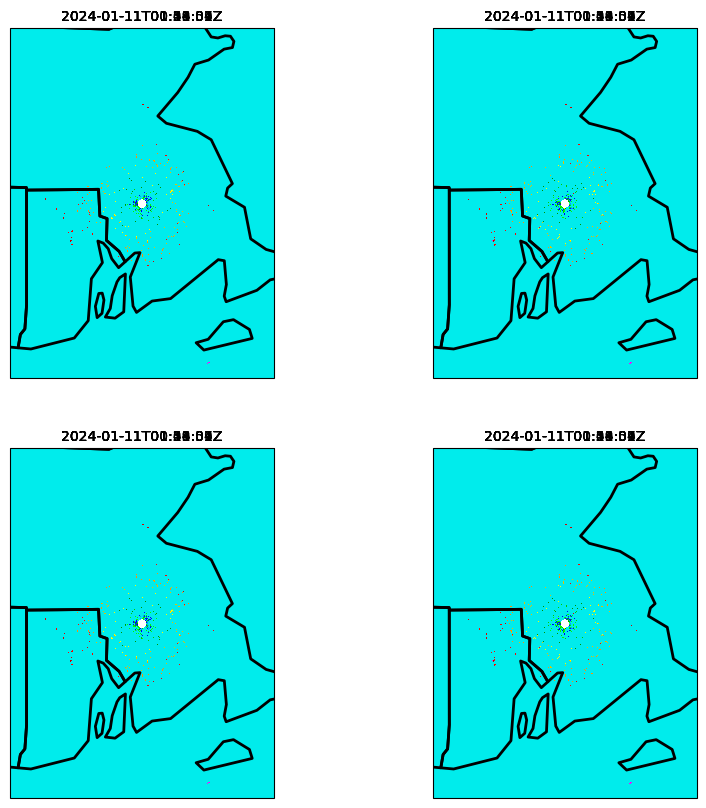

In [13]:
# New figure with specified projection
fig = plt.figure(figsize = (10, 10))
axes = []
artists = []

# Try to make things lay out more automatically
nrows = 2
ncols = int(len(catalogs) / nrows)

# First loop over all of the catalogs of data we got.
for panel, catalog in list(enumerate(catalogs, 1)):
	
	# Create a new axes for each of these -- corresponds to the radar product
	ax = fig.add_subplot(nrows, ncols, panel, projection = proj)
	axes.append(ax)
	
	# Set up the maps
	ax.add_feature(state_borders, edgecolor = 'black', linewidth = 2, zorder = 2)
	
	# List of list of artists. Assembles the things to draw for this particular axes for
	#each frame of the animation
	ax_artists = []
	
	# Loop over each of the datasets in the catalog, sorting by name, which gets
	# us time sorting
	for ds_name in sorted(catalog.datasets):
		ds = catalog.datasets[ds_name]
		data = Dataset(ds.access_urls['CdmRemote'])
		
		# Quick way to find the name of the variable we want from the file
		# without hard-coding it. Look for 2D variables without the name ending in RAW
		field_name = [var.name for var in data.variables.values() if var.ndim >= 2 and not var.name.endswith('_HI')][0]
		
		# Plot (manually) the time of the product as the title for the panel
		text = ax.text(0.5, 1.02, data.time_coverage_start, ha = 'center', transform = ax.transAxes)
		
		# Call our function to plot the data
		mesh = plot_radar(data, field_name)
		
		# Add to the list of artists
		ax_artists.append([text, mesh])
		
	# Add the list of artist for this axes to the list overall
	artists.append(ax_artists)
	
# Take the per-axis lists of artists and join them together to get
# one list, where each entry is a list of all artists to draw in a frame.
new_artists = []
for panel_artists in zip(*artists):
	frame = []
	for panel in panel_artists:
		frame.extend(panel)
	new_artists.append(frame)

In [14]:
# Tell matplotlib to use the javascript+html rendering for animation -- for the notebook
plt.rcParams['animation.html'] = 'jshtml'

In [15]:
anim = ArtistAnimation(fig, new_artists, interval = 100)
anim

In [16]:
catalogs

[Radar NEXRAD Level II Radar from IDD datasets in near real time,
 Radar NEXRAD Level II Radar from IDD datasets in near real time,
 Radar NEXRAD Level II Radar from IDD datasets in near real time,
 Radar NEXRAD Level II Radar from IDD datasets in near real time]

In [17]:
catalog.datasets

['Level2_KBOX_20240111_0126.ar2v', 'Level2_KBOX_20240111_0133.ar2v', 'Level2_KBOX_20240111_0051.ar2v', 'Level2_KBOX_20240111_0104.ar2v', 'Level2_KBOX_20240111_0058.ar2v', 'Level2_KBOX_20240111_0111.ar2v', 'Level2_KBOX_20240111_0044.ar2v', 'Level2_KBOX_20240111_0119.ar2v']